In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
import os
path="/content/gdrive/My Drive"
os.chdir(path)
os.listdir(path)

['net_config (6).cpython-37.pyc',
 '.ipynb_checkpoints',
 'net_config (5).cpython-37.pyc',
 'EnsembleModel (1).cpython-37.pyc',
 'net_config (4).cpython-37.pyc',
 'EnsembleModel.cpython-37.pyc',
 'net_config (3).cpython-37.pyc',
 'seqGAN',
 'ML_dialogue',
 'seqGAN_tran.ipynb',
 '6000J',
 '5002',
 '5012',
 'exam5003',
 'net_config (2).cpython-37.pyc',
 'MultiLabelTextClassification',
 'net_config (1).cpython-37.pyc',
 'net_config.cpython-37.pyc',
 'MAAL.ipynb',
 '5002final',
 'MSBD5002_Fall2021_Final_Data',
 'processed_text.csv',
 'train.csv']

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import jieba
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [101]:
data = pd.read_csv('/content/gdrive/My Drive/5002/final/Q7/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)
data.columns = ['target','id','date','flag','user','text']

In [7]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
data['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [22]:
#flag is useless
data['flag'].value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

In [5]:
data.drop(['flag'],axis=1, inplace=True)
data.drop(['user'],axis=1, inplace=True)

In [24]:
data['date'].value_counts()

Mon Jun 15 12:53:14 PDT 2009    20
Fri May 22 05:10:17 PDT 2009    17
Mon Jun 15 13:39:50 PDT 2009    17
Fri May 29 13:40:04 PDT 2009    17
Fri Jun 05 14:13:07 PDT 2009    16
                                ..
Mon Apr 20 04:09:04 PDT 2009     1
Wed Jun 17 23:13:43 PDT 2009     1
Sun May 17 10:37:52 PDT 2009     1
Thu Jun 25 08:43:59 PDT 2009     1
Fri May 22 01:40:14 PDT 2009     1
Name: date, Length: 774363, dtype: int64

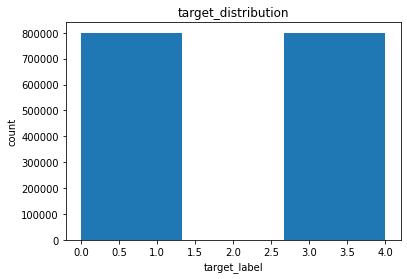

In [15]:
plt.hist(data['target'], bins = 3)
plt.xlabel('target_label')
plt.ylabel('count')
plt.title('target_distribution')
plt.show()

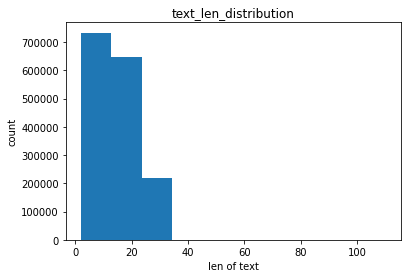

In [67]:
l=[]
for i in data['text']:
  l.append(len(i.split(' ')))
plt.hist(l)
plt.xlabel('len of text')
plt.ylabel('count')
plt.title('text_len_distribution')
plt.show()

(0.0, 60.0)

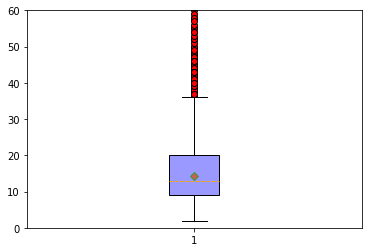

In [70]:
plt.boxplot(x = l, # 指定绘图数据
 
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
 
            showmeans=True, # 以点的形式显示均值
 
            boxprops = {'color':'black','facecolor':'#9999ff'}, # 设置箱体属性，填充色和边框色
 
            flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}, # 设置异常值属性，点的形状、填充色和边框色
 
            meanprops = {'marker':'D','markerfacecolor':'indianred'}, # 设置均值点的属性，点的形状、填充色
 
            medianprops = {'linestyle':'--','color':'orange'}) # 设置中位数线的属性，线的类型和颜色
 
# 设置y轴的范围
 
plt.ylim(0,60)

In [74]:
def clean_txt(text): 
    text = BeautifulSoup(text,'html.parser').get_text() #remove html tag 
    text = re.sub(r'[^a-zA-Z]',' ',text)  
    text = re.sub(r"@\S+", "", text) #remove@ and following signal
    text = re.sub(r"http:\S+", "", text) #remove url 
    text = text.lower()     
    stopwords = nltk.corpus.stopwords.words('english') 
    text = [s for s in text.replace(",", "").replace(".", "").split(' ') if s != '']
    words_list = [w for w in text if w not in stopwords]
    return words_list

In [75]:
test = pd.read_csv('/content/gdrive/My Drive/5002/final/Q7/testdata.manual.2009.06.14.csv',encoding='ISO-8859-1',header=None)
test.columns = ['target','id','date','flag','user','text']

In [10]:
test.head()

,target,id,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [30]:
text_list=[]
for i in data['text']:
  text_list.append(clean_txt(i))


In [11]:
text_list = text_list.values

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np
from gensim.models import Word2Vec
from torch import multiprocessing




def get_index(sentence):
    sequence = []
    for word in sentence:
        try:
            sequence.append(word_dict[word])
        except KeyError:
            pass
    return sequence

def list_pad_2D(data, max_len, val):
    tmp = []
    for i in data:
        if (len(i) >= max_len):
            tmp.append(i[0:max_len])
        else:
            tmp.append(i + [val] * (max_len - len(i)))
    return np.array(tmp)

def prepocessing(train, test):
    max_len = 30
    save_dim = 64
    #for i in train:
      #train_text.append(clean_txt(i))
    train_text = pd.read_csv('processed_text.csv', header=None).fillna(0)
    train_text = train_text.values.tolist()
    for i in range(len(train_text)):
      train_text[i] = train_text[i][:train_text[i].index(0)] if 0 in train_text[i] else train_text[i]
    test_text=[]
    for i in test:
      test_text.append(clean_txt(i))
    train_text = np.array(train_text)
    test_text = np.array(test_text)    

    print("-------Word2vec begin")

    model = Word2Vec(sentences=np.concatenate([train_text, test_text], axis=0), size=save_dim, window=10, min_count=3, workers=multiprocessing.cpu_count(), sg=1)
    
    global word_dict
    word_dict = {word: index+1 for index, word in enumerate(model.wv.vocab)}

    train_text = list_pad_2D(list(map(get_index, train_text)), max_len, 0)
    test_text = list_pad_2D(list(map(get_index, test_text)), max_len, 0)
    return train_text, test_text, model
    
    

In [102]:
train_text, test_text, wvmodel = prepocessing(data['text'],test['text'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


-------Word2vec begin


In [76]:
train_text = pd.read_csv('processed_text.csv', header=None).fillna(0)
train_text = train_text.values.tolist()
for i in range(len(train_text)):
    train_text[i] = train_text[i][:train_text[i].index(0)] if 0 in train_text[i] else train_text[i]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
data['text'] = train_text
data.to_csv('Q7_clean.csv',header=None)

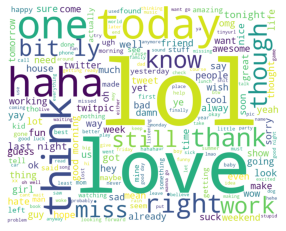

In [82]:
s = ''
for i in range(len(train_text)):
  s+=' '.join(train_text[i])
  s+=' '
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(
               background_color='white',
               width=1000,
               height=800,
               ).generate(s)
wc.to_file('wordcloud.png') 
plt.imshow(wc)  
plt.axis('off')
plt.show() 

In [84]:
df1 = data[data['target'] == 0] #negative
df1 = df1['text']
df2 = data[data['target'] == 4] #positive
df2 = df2['text']

In [85]:
def word_count(df):
    text_dic = {}
    for row in df:
      for w in row:
        if w in text_dic.keys():
          text_dic[w]+=1
        else:
          text_dic[w]=1
    return text_dic
neg_dic = word_count(df1)
pos_dic = word_count(df2)
total_dic = neg_dic.copy()
total_dic.update(pos_dic)

In [89]:
def dic2df(dic):
  res = []
  for item in dic.items():
    res.append(list(item))
  res = pd.DataFrame(res)
  return res
neg_df = dic2df(neg_dic)
pos_df = dic2df(pos_dic)
neg_df.columns = ['key','negative']
pos_df.columns = ['key','positive']
total_df=pd.merge(neg_df,pos_df,how="outer")
total_df = total_df.fillna(0)
total_df['total']=total_df['negative']+total_df['positive']
total_df.to_csv('Q7_freq.csv')

In [96]:
neg_df.sort_values(by=['negative'],ascending=False)

,key,negative
32,go,45661
126,get,45622
189,work,45484
12,day,41482
38,like,41062
...,...,...
161060,trailofdan,1
161061,jighooligan,1
161063,prettypaige,1
161064,starlaboob,1


In [97]:
pos_df.sort_values(by=['positive'],ascending=False)

,key,positive
494,good,62161
84,day,48366
0,love,47868
180,http,47218
65,like,37529
...,...,...
193423,staceybethh,1
193424,sweeeeeeeeeeeeeeeeeeeeeeeeeeeeeet,1
193425,laurenblue,1
193426,lksugarman,1


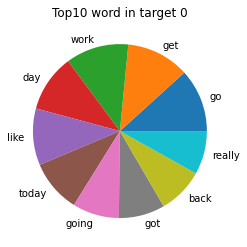

In [99]:
data = neg_df.sort_values(by=['negative'],ascending=False).values

plt.pie(data[:10,1],
        labels=data[:10,0],
       )
plt.title("Top10 word in target 0")
plt.show()

In [21]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score ,roc_curve, auc, roc_auc_score
import seaborn as sns

In [22]:
x_train,x_val,y_train,y_val = train_test_split(train_text, data['target'].values, test_size = 0.1,random_state=1)

In [50]:
y_val = np.where(y_val == 4, 1, y_val)
a

array([0, 0, 0, ..., 1, 0, 0])

In [65]:
#ramdom forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, n_jobs=4, max_depth=30)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)
y_true = y_val

              precision    recall  f1-score   support

           0       0.60      0.72      0.65     79836
           4       0.65      0.52      0.58     80164

    accuracy                           0.62    160000
   macro avg       0.62      0.62      0.61    160000
weighted avg       0.62      0.62      0.61    160000



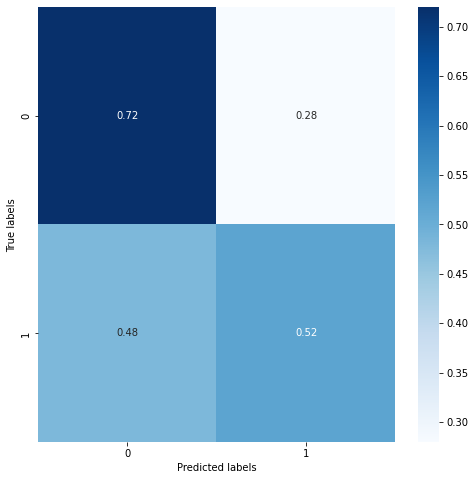

In [59]:
accuracy_score(y_true, y_pred)
classification_report(y_true, y_pred)
 
 #peint calssification report
print(classification_report(y_true, y_pred))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, y_pred, labels=[0,4])
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
#plt.xticks([0,4],[0,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [63]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=20,max_depth=30)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_val)

              precision    recall  f1-score   support

           0       0.66      0.71      0.69     79836
           4       0.69      0.63      0.66     80164

    accuracy                           0.67    160000
   macro avg       0.67      0.67      0.67    160000
weighted avg       0.67      0.67      0.67    160000



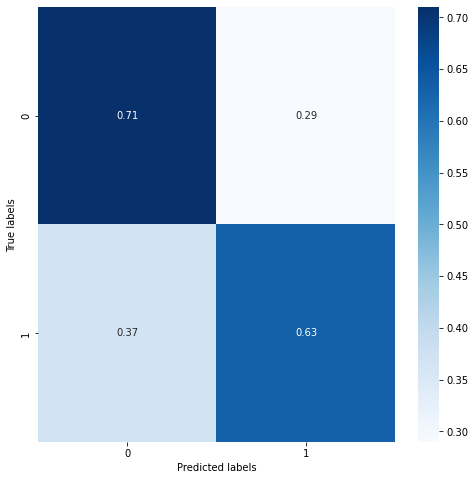

In [64]:
accuracy_score(y_true, y_pred)
classification_report(y_true, y_pred)
 
 #peint calssification report
print(classification_report(y_true, y_pred))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, y_pred, labels=[0,4])
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
#plt.xticks([0,4],[0,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**NNs**

In [28]:
class TextDataset(Dataset):
    def __init__(self, x, y, test=False):
        self.x = x
        self.y = y
        self.test = test

    def __getitem__(self, idx):
        if not self.test:
          return self.x[idx], self.y[idx]
        else:
          return self.x[idx]

    def __len__(self):
        return self.x.shape[0]

In [53]:
class BiLSTM(nn.Module):
    def __init__(self, classes, vocab_size=None, emb_size=None, emb_init=None, padding_idx=0):
        super(BiLSTM, self).__init__()

        if emb_init is not None:
            if vocab_size is not None:
                assert vocab_size == emb_init.shape[0]
            if emb_size is not None:
                assert emb_size == emb_init.shape[1]
            vocab_size, emb_size = emb_init.shape

        self.dim = 128

        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx, sparse=False,
                                _weight=torch.from_numpy(emb_init).float() if emb_init is not None else None)
        #self.emb.weight.requires_grad = self.emb_trainable  # if save gradient?

        self.lstm = nn.LSTM(emb_size, self.dim, num_layers=2, bidirectional=True, batch_first=True, dropout=0.2, bias=True)
          
        self.L1 = nn.Linear(self.dim*2, self.dim, bias=True)
        self.L2 = nn.Linear(self.dim, classes, bias=True)

        nn.init.xavier_normal(self.L1.weight)
        nn.init.xavier_normal(self.L2.weight)
    

    def attention_net(self, x, query, mask=None): 
        d_k = query.size(-1) 
        scores = torch.matmul(query, x.transpose(1, 2)) / math.sqrt(d_k)  
        alpha_n = F.softmax(scores, dim=-1) 
        context = torch.matmul(alpha_n, x).sum(1) 
        return context, alpha_n



    def forward(self, text ):
        embe_out = self.emb(text)  # (batch, sent_len, embed_dim)
        lstm_output, _ = self.lstm(embe_out)
        attn_output,_ = self.attention_net(lstm_output, lstm_output)
        logits = F.relu(self.L1(attn_output))
        logits = self.L2(logits)
        
        return logits




class XMLCNN(nn.Module):
    def __init__(self, classes,vocab_size=None, emb_size=None, emb_init=None, padding_idx=0):
        super(XMLCNN, self).__init__()

        if emb_init is not None:
            if vocab_size is not None:
                assert vocab_size == emb_init.shape[0]
            if emb_size is not None:
                assert emb_size == emb_init.shape[1]
            vocab_size, emb_size = emb_init.shape

        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx, sparse=False,
                                _weight=torch.from_numpy(emb_init).float() if emb_init is not None else None)
        self.ks = 3 
        self.dynamic_pool_length = 300 
        self.num_bottleneck_hidden = 512
        self.output_channel = 128
        self.conv1 = nn.Conv2d(1, self.output_channel, (2, emb_size), padding=(1, 0))
        self.conv2 = nn.Conv2d(1, self.output_channel, (4, emb_size), padding=(3, 0))
        self.conv3 = nn.Conv2d(1, self.output_channel, (8, emb_size), padding=(7, 0))
        self.pool = nn.AdaptiveMaxPool1d(self.dynamic_pool_length)  # Adaptive pooling

        self.mlp = nn.Sequential(
            nn.Linear(self.ks * self.output_channel * self.dynamic_pool_length,
                      self.num_bottleneck_hidden),
            #nn.Dropout(self.dropout),
            nn.Tanh(),
            nn.Linear(self.num_bottleneck_hidden, emb_size, bias=True),
        )

        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)

    def forward(self, x):
        embe_out = self.emb(x)  # (batch, sent_len, embed_dim)
        x = embe_out.unsqueeze(1)  # (batch, channel_input, sent_len, embed_dim)

        x = [F.relu(self.conv1(x)).squeeze(3), F.relu(self.conv2(x)).squeeze(3), F.relu(self.conv3(x)).squeeze(3)]
        x = [self.pool(i).squeeze(2) for i in x]

        # (batch, channel_output) * ks
        x = torch.cat(x, 1)  # (batch, channel_output * ks)
        logit = self.mlp(x.view(-1, self.ks * self.output_channel * self.dynamic_pool_length))  # (batch, target_size)
        return logit

In [41]:
from tqdm import tqdm
def train(model, train_loader, optimizer,  criterion, device, batch_size):
    model.train()
    l = []
    #print(1)
    for step, batch in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        text, y = batch
        
        text = text.long()
        y = y.long()
        text = text.to(device)
        y = y.to(device)

        logits = model(text)
        loss = criterion(logits, y)
        l.append(loss.item())
            
      
        loss.backward()
        optimizer.step()
    
    return np.mean(l)


In [23]:
y_train_nn = np.where(y_train == 4, 1, y_train)
y_val_nn = np.where(y_val == 4, 1, y_val)

In [103]:
emb_weight = wvmodel.wv.vectors
vocab_size, emb_size_doc = emb_weight.shape
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)
lstm = BiLSTM(2, vocab_size, emb_size_doc, emb_weight).to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 512

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [104]:
lstm

BiLSTM(
  (emb): Embedding(135319, 64, padding_idx=0)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (L1): Linear(in_features=256, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=2, bias=True)
)

In [35]:
train_dataset = TextDataset(x_train, y_train_nn, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [45]:
count=0
l=[]
for e in range(100):
  loss = train(lstm, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      l.append(loss)
      print("Final loss: %1.5f" % (loss))
      break
  if e % 1 == 0:
      l.append(loss)
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

2813it [01:25, 32.87it/s]


Epoch: 0, loss: 0.48954


2813it [01:25, 32.83it/s]


Epoch: 1, loss: 0.47498


2813it [01:26, 32.61it/s]


Epoch: 2, loss: 0.47134


2813it [01:26, 32.63it/s]


Epoch: 3, loss: 0.47013


2813it [01:25, 32.74it/s]


Epoch: 4, loss: 0.46966


2813it [01:25, 32.91it/s]


Epoch: 5, loss: 0.46943


2813it [01:25, 32.96it/s]


Epoch: 6, loss: 0.46918


2813it [01:25, 32.97it/s]


Epoch: 7, loss: 0.46898


2813it [01:25, 32.75it/s]


Epoch: 8, loss: 0.46882


2813it [01:26, 32.71it/s]


Epoch: 9, loss: 0.46857


2813it [01:25, 32.92it/s]


Epoch: 10, loss: 0.46837


2813it [01:25, 32.90it/s]


Epoch: 11, loss: 0.46823


2813it [01:26, 32.70it/s]


Epoch: 12, loss: 0.46805


2813it [01:26, 32.63it/s]


Epoch: 13, loss: 0.46782


2813it [01:26, 32.60it/s]


Epoch: 14, loss: 0.46778


2813it [01:26, 32.70it/s]


Epoch: 15, loss: 0.46758


2813it [01:26, 32.63it/s]


Epoch: 16, loss: 0.46758


2813it [01:26, 32.65it/s]


Epoch: 17, loss: 0.46756


2813it [01:26, 32.60it/s]


Epoch: 18, loss: 0.46752


2813it [01:25, 32.86it/s]


Epoch: 19, loss: 0.46744


509it [00:15, 32.16it/s]


KeyboardInterrupt: ignored

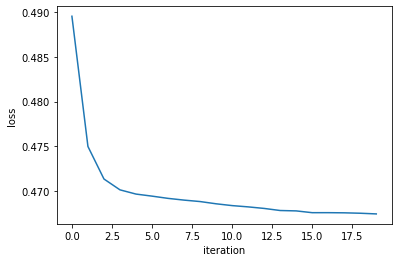

In [46]:
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(range(0,20), l)
plt.show()

In [47]:
val_dataset = TextDataset(x_val, y_val_nn, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [50]:
def evaluation(model, val_loader, batch_size):
  preds = []
  probs = []
  y_list=[]
  for i,batch in enumerate(val_loader):
      #print(1) 
      text, y = batch      
      text = text.long()
      y = y.long()

      text = text.to(device)
      y_list.append(y.numpy())
      with torch.no_grad():
        outputs = model(text)
        probabilities = F.softmax(outputs.cpu(), dim=1)
        _, pred = torch.max(probabilities, dim=1)
        probs.append(probabilities.tolist())
        preds.append(pred)
  return np.concatenate(preds,axis=0), np.concatenate(probs,axis=0), np.array([i for i in np.concatenate(y_list,axis=0)])

              precision    recall  f1-score   support

           0       0.78      0.77      0.78     79836
           1       0.78      0.78      0.78     80164

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000



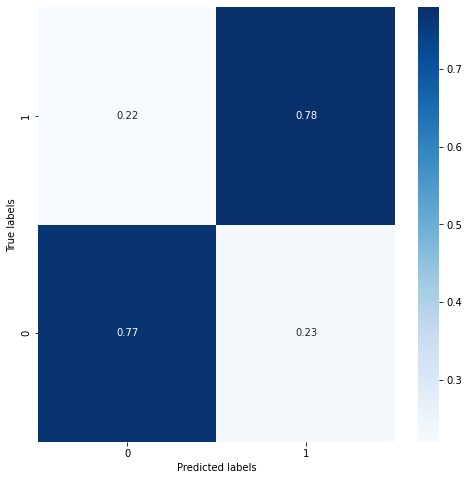

In [51]:
preds, probs, y_true = evaluation(lstm, val_loader, batch_size)
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(2))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 2)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**CNN**

In [105]:
emb_weight = wvmodel.wv.vectors
vocab_size, emb_size_doc = emb_weight.shape
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)
cnn = XMLCNN(2, vocab_size, emb_size_doc, emb_weight).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)
batch_size = 1024

In [106]:
cnn

XMLCNN(
  (emb): Embedding(135319, 64, padding_idx=0)
  (conv1): Conv2d(1, 128, kernel_size=(2, 64), stride=(1, 1), padding=(1, 0))
  (conv2): Conv2d(1, 128, kernel_size=(4, 64), stride=(1, 1), padding=(3, 0))
  (conv3): Conv2d(1, 128, kernel_size=(8, 64), stride=(1, 1), padding=(7, 0))
  (pool): AdaptiveMaxPool1d(output_size=300)
  (mlp): Sequential(
    (0): Linear(in_features=115200, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=64, bias=True)
  )
)

In [59]:
count=0
l=[]
for e in range(100):
  loss = train(cnn, train_loader, optimizer, criterion, device, batch_size)
  if e==0:
    last=loss
  else:
    pre=loss
    if (last-pre)/last <=0.01:
      count+=1
    if count==5:
      l.append(loss)
      print("Final loss: %1.5f" % (loss))
      break
  if e % 1 == 0:
      l.append(loss)
      print("Epoch: %d, loss: %1.5f" % (e, loss)) 

2813it [11:51,  3.96it/s]


Epoch: 0, loss: 0.54432


2813it [11:51,  3.95it/s]


Epoch: 1, loss: 0.47203


2813it [11:51,  3.95it/s]


Epoch: 2, loss: 0.46527


2813it [11:51,  3.95it/s]


Epoch: 3, loss: 0.46330


2813it [11:51,  3.95it/s]


Epoch: 4, loss: 0.46186


2813it [11:51,  3.95it/s]


Epoch: 5, loss: 0.46079


2813it [11:51,  3.95it/s]


Epoch: 6, loss: 0.46010


2813it [11:51,  3.95it/s]


Epoch: 7, loss: 0.45948


619it [02:36,  3.95it/s]


KeyboardInterrupt: ignored

              precision    recall  f1-score   support

           0       0.81      0.74      0.77     79836
           1       0.76      0.82      0.79     80164

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000



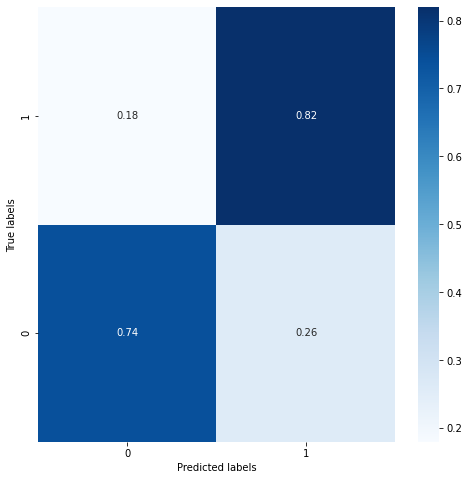

In [60]:
preds, probs, y_true = evaluation(cnn, val_loader, batch_size)
acc = accuracy_score(y_true, preds)
classification_report(y_true, preds)
 
 #peint calssification report
print(classification_report(y_true, preds))
 
 #build confusion matrix
con_mat = confusion_matrix(y_true, preds, labels=range(2))
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis] # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
 #plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 2)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()